In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import pandas_profiling as pp

# models
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor 
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")


In [2]:
valid_part = 0.3
pd.set_option('max_columns',100)

In [3]:
train0 = pd.read_csv('vehicles.csv')
train0.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7119256118,https://mohave.craigslist.org/ctd/d/lake-havas...,mohave county,https://mohave.craigslist.org,3495,2012.0,jeep,patriot,like new,4 cylinders,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN,silver,https://images.craigslist.org/00B0B_k2AXIJ21ok...,"THIS 2012 JEEP PATRIOT IS A 4CYL. AC, STEREO, ...",NaN,az,34.4554,-114.2690
1,7120880186,https://oregoncoast.craigslist.org/cto/d/warre...,oregon coast,https://oregoncoast.craigslist.org,13750,2014.0,bmw,328i m-sport,good,NaN,gas,76237.0,clean,automatic,NaN,rwd,NaN,sedan,grey,https://images.craigslist.org/00U0U_3cLk0WGOJ8...,Selling my 2014 BMW 328i with the following be...,NaN,or,46.1837,-123.8240
2,7115048251,https://greenville.craigslist.org/cto/d/sparta...,greenville / upstate,https://greenville.craigslist.org,2300,2001.0,dodge,caravan,excellent,6 cylinders,gas,199000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00k0k_t4WqYn5nDC...,"01 DODGE CARAVAN,3.3 ENGINE,AUT TRANS,199000 M...",NaN,sc,34.9352,-81.9654
3,7119250502,https://mohave.craigslist.org/cto/d/lake-havas...,mohave county,https://mohave.craigslist.org,9000,2004.0,chevrolet,colorado ls,excellent,5 cylinders,gas,54000.0,clean,automatic,1GCCS196448191644,rwd,mid-size,pickup,red,https://images.craigslist.org/00J0J_lJEzfeVLHI...,"2004 Chevy Colorado LS, ONLY 54000 ORIGINAL MI...",NaN,az,34.4783,-114.2710
4,7120433904,https://maine.craigslist.org/ctd/d/searsport-t...,maine,https://maine.craigslist.org,0,2021.0,NaN,Honda-Nissan-Kia-Ford-Hyundai-VW,NaN,NaN,other,NaN,clean,other,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/01010_j0IW34mCsm...,CALL: 207.548.6500 TEXT: 207.407.5598 **WE FI...,NaN,me,44.4699,-68.8963


In [4]:
drop_columns = ['id','url', 'region', 'region_url', 'model', 'title_status', 'vin', 'size', 'image_url', 'description', 'lat','long','county']
train0 = train0.drop(columns = drop_columns)

In [5]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435849 entries, 0 to 435848
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         435849 non-null  int64  
 1   year          434732 non-null  float64
 2   manufacturer  415102 non-null  object 
 3   condition     249043 non-null  object 
 4   cylinders     269465 non-null  object 
 5   fuel          432858 non-null  object 
 6   odometer      360701 non-null  float64
 7   transmission  433703 non-null  object 
 8   drive         313838 non-null  object 
 9   type          318741 non-null  object 
 10  paint_color   300602 non-null  object 
 11  state         435849 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 39.9+ MB


In [6]:
train0 = train0.dropna()
train0.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
3,9000,2004.0,chevrolet,excellent,5 cylinders,gas,54000.0,automatic,rwd,pickup,red,az
7,8500,2005.0,ford,excellent,6 cylinders,gas,62800.0,automatic,rwd,convertible,silver,me
12,2750,2006.0,chevrolet,good,8 cylinders,gas,165000.0,automatic,4wd,truck,white,me
19,24930,2017.0,subaru,excellent,4 cylinders,gas,32989.0,automatic,4wd,SUV,grey,mt
26,3200,1998.0,volkswagen,good,4 cylinders,gas,98186.0,manual,rwd,coupe,blue,mt


In [7]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = train0.columns.values.tolist()
for col in features:
    if train0[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encoding categorical features
for col in categorical_columns:
    if col in train0.columns:
        le = LabelEncoder()
        le.fit(list(train0[col].astype(str).values))
        train0[col] = le.transform(list(train0[col].astype(str).values))



In [8]:
train0['year'] = (train0['year']-1900).astype(int)
train0['odometer'] = train0['odometer'].astype(int)

In [9]:
train0.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
3,9000,104,7,0,4,2,54000,0,2,8,8,3
7,8500,105,13,0,5,2,62800,0,2,2,9,21
12,2750,106,7,2,6,2,165000,0,0,10,10,21
19,24930,117,37,0,3,2,32989,0,0,0,5,26
26,3200,98,40,2,3,2,98186,1,2,3,1,26


In [10]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124793 entries, 3 to 435846
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   price         124793 non-null  int64
 1   year          124793 non-null  int32
 2   manufacturer  124793 non-null  int64
 3   condition     124793 non-null  int64
 4   cylinders     124793 non-null  int64
 5   fuel          124793 non-null  int64
 6   odometer      124793 non-null  int32
 7   transmission  124793 non-null  int64
 8   drive         124793 non-null  int64
 9   type          124793 non-null  int64
 10  paint_color   124793 non-null  int64
 11  state         124793 non-null  int64
dtypes: int32(2), int64(10)
memory usage: 11.4 MB


In [11]:
train0['price'].value_counts()

0        4552
4500     1403
5995     1358
3500     1322
6995     1316
         ... 
5472        1
19755       1
7457        1
7393        1
19734       1
Name: price, Length: 5547, dtype: int64

In [12]:
train0 = train0[train0['price'] > 1000]
train0 = train0[train0['price'] < 40000]
# Rounded ['odometer'] to 5000
train0['odometer'] = train0['odometer'] // 5000
train0 = train0[train0['year'] > 110]

In [13]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60870 entries, 19 to 435840
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   price         60870 non-null  int64
 1   year          60870 non-null  int32
 2   manufacturer  60870 non-null  int64
 3   condition     60870 non-null  int64
 4   cylinders     60870 non-null  int64
 5   fuel          60870 non-null  int64
 6   odometer      60870 non-null  int32
 7   transmission  60870 non-null  int64
 8   drive         60870 non-null  int64
 9   type          60870 non-null  int64
 10  paint_color   60870 non-null  int64
 11  state         60870 non-null  int64
dtypes: int32(2), int64(10)
memory usage: 5.6 MB


In [14]:
train0.corr()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
price,1.000000,0.451994,-0.028563,0.115130,0.500969,-0.181776,-0.242929,0.182608,-0.245597,0.034775,0.042705,0.004828
year,0.451994,1.000000,0.039877,0.133841,-0.096874,0.065522,-0.362668,0.093475,-0.020978,0.012367,0.042515,-0.014672
manufacturer,-0.028563,0.039877,1.000000,-0.008770,-0.200279,-0.056015,-0.030149,0.042601,-0.099195,0.050371,-0.018589,-0.006306
condition,0.115130,0.133841,-0.008770,1.000000,0.053672,0.030514,-0.071651,0.143540,0.033947,0.027081,0.002252,-0.000423
cylinders,0.500969,-0.096874,-0.200279,0.053672,1.000000,-0.098038,0.071667,0.102699,-0.141777,0.072877,0.042781,0.021634
fuel,-0.181776,0.065522,-0.056015,0.030514,-0.098038,1.000000,-0.104450,0.087760,0.081593,-0.119522,-0.049588,-0.032950
odometer,-0.242929,-0.362668,-0.030149,-0.071651,0.071667,-0.104450,1.000000,-0.114799,-0.031043,0.034483,0.020085,0.014536
transmission,0.182608,0.093475,0.042601,0.143540,0.102699,0.087760,-0.114799,1.000000,0.045928,0.002393,-0.019678,-0.024077
drive,-0.245597,-0.020978,-0.099195,0.033947,-0.141777,0.081593,-0.031043,0.045928,1.000000,0.124981,0.075445,-0.087186
type,0.034775,0.012367,0.050371,0.027081,0.072877,-0.119522,0.034483,0.002393,0.124981,1.000000,0.087766,-0.002102


In [15]:
train0.describe()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
count,60870.000000,60870.000000,60870.000000,60870.000000,60870.000000,60870.000000,60870.000000,60870.000000,60870.000000,60870.000000,60870.000000,60870.000000
mean,15983.185313,114.283177,18.993264,1.152012,4.398899,1.927567,16.134483,0.159619,0.720831,6.113603,5.709479,24.100230
std,8397.447147,2.304149,11.495406,1.234212,1.276746,0.530551,15.605430,0.502718,0.731753,4.154347,4.062670,15.019661
min,1061.000000,111.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,112.000000,10.000000,0.000000,3.000000,2.000000,8.000000,0.000000,0.000000,0.000000,1.000000,9.000000
50%,14250.000000,114.000000,14.000000,0.000000,5.000000,2.000000,15.000000,0.000000,1.000000,8.000000,8.000000,23.000000
75%,21395.000000,116.000000,31.000000,2.000000,5.000000,2.000000,22.000000,0.000000,1.000000,9.000000,10.000000,37.000000
max,39999.000000,121.000000,41.000000,5.000000,7.000000,4.000000,1629.000000,2.000000,2.000000,12.000000,11.000000,50.000000


In [16]:
#pp.ProfileReport(train0)

In [17]:
target_name = 'price'
train_target0 = train0[target_name]
train0 = train0.drop([target_name], axis=1)

In [18]:
train0, test0, train_target0, test_target0 = train_test_split(train0, train_target0, test_size=0.2, random_state=0)

In [19]:
# For boosting model
train0b = train0
train_target0b = train_target0
# Synthesis valid as test for selection models
trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size=valid_part, random_state=0)

In [20]:
scaler = StandardScaler()
train0 = pd.DataFrame(scaler.fit_transform(train0), columns = train0.columns)

In [21]:
train0.head()

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
0,0.311650,-1.040793,0.688127,1.252857,0.137755,0.305670,-0.315523,1.745705,0.934635,1.056601,1.458450
1,-0.557418,1.745613,0.688127,0.470659,0.137755,-0.396938,3.672723,-0.985372,0.453174,-1.405476,-1.540751
2,0.311650,-0.518342,0.688127,0.470659,0.137755,0.227603,1.678600,-0.985372,0.934635,-0.174438,0.058823
3,2.049786,-0.518342,1.498484,-1.093738,0.137755,-1.099547,-0.315523,0.380167,0.693905,1.056601,0.325418
4,-0.557418,-0.431267,-0.932585,1.252857,0.137755,1.086346,-0.315523,1.745705,-1.472670,1.056601,1.258503


In [22]:
train, test, target, target_test = train_test_split(train0, train_target0, test_size=valid_part, random_state=0)

In [23]:
train.head()

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
27855,-0.991952,-0.518342,-0.932585,1.252857,-3.637222,-0.631141,-0.315523,-0.985372,0.934635,-1.405476,-1.007560
27348,-1.426486,1.571463,-0.932585,-1.093738,0.137755,0.071467,-0.315523,-0.985372,-1.472670,-1.405476,0.791961
30708,0.311650,1.745613,0.688127,-1.093738,0.137755,-0.084668,-0.315523,0.380167,-0.509748,0.810393,0.858610
15386,0.746184,0.091184,-0.932585,0.470659,0.137755,0.383738,-0.315523,-0.985372,-1.472670,0.564185,0.192121
37459,0.746184,-0.170041,-0.932585,-1.093738,0.137755,-1.021479,-0.315523,-0.985372,-1.472670,0.810393,0.725312


In [24]:
test.head()

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
46151,2.049786,-0.518342,-0.932585,0.470659,0.137755,-1.099547,-0.315523,1.745705,1.175366,1.056601,-0.274422
11732,-1.426486,-0.518342,-0.932585,0.470659,0.137755,1.476685,-0.315523,-0.985372,-1.472670,0.317978,0.925259
41922,-0.557418,1.049012,1.498484,0.470659,0.137755,0.696008,-0.315523,0.380167,0.693905,-0.174438,0.458716
18915,-0.991952,-1.040793,-0.932585,0.470659,0.137755,-0.162735,-0.315523,0.380167,0.693905,-1.405476,-0.341071
22745,0.311650,-0.779568,-0.932585,-1.093738,0.137755,-0.084668,-0.315523,0.380167,0.693905,0.810393,0.858610


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34087 entries, 27855 to 2732
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          34087 non-null  float64
 1   manufacturer  34087 non-null  float64
 2   condition     34087 non-null  float64
 3   cylinders     34087 non-null  float64
 4   fuel          34087 non-null  float64
 5   odometer      34087 non-null  float64
 6   transmission  34087 non-null  float64
 7   drive         34087 non-null  float64
 8   type          34087 non-null  float64
 9   paint_color   34087 non-null  float64
 10  state         34087 non-null  float64
dtypes: float64(11)
memory usage: 3.1 MB


In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14609 entries, 46151 to 30951
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          14609 non-null  float64
 1   manufacturer  14609 non-null  float64
 2   condition     14609 non-null  float64
 3   cylinders     14609 non-null  float64
 4   fuel          14609 non-null  float64
 5   odometer      14609 non-null  float64
 6   transmission  14609 non-null  float64
 7   drive         14609 non-null  float64
 8   type          14609 non-null  float64
 9   paint_color   14609 non-null  float64
 10  state         14609 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [27]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []

In [28]:
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

In [29]:
def acc_boosting_model(num,model,train,test,num_iteration=0):
    # Calculation of accuracy of boosting model by different metrics
    
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', targetb[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(targetb, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(targetb, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(targetb, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_testb[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_testb, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_testb, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_testb, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [30]:
def acc_model(num,model,train,test):
    # Calculation of accuracy of model акщь Sklearn by different metrics   
  
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [31]:
# Linear Regression

linreg = LinearRegression()
linreg.fit(train, target)
acc_model(0,linreg,train,test)

target =  [26000  4800 13995 22995 14977]
ytrain =  [24902.10375549  7117.07263298 12080.19551374 20977.37390156
 16240.22323349]
acc(r2_score) for train = 58.38
acc(relative error) for train = 24.93
acc(rmse) for train = 541444.24
target_test = [35966  4500  6895  8997  9995]
ytest = [23859.49359683 11519.95134343 14411.99262681 13282.5948311
 11270.10549085]
acc(r2_score) for test = 58.66
acc(relative error) for test = 24.96
acc(rmse) for test = 541022.8


In [32]:
# Support Vector Machines

svr = SVR()
svr.fit(train, target)
acc_model(1,svr,train,test)

target =  [26000  4800 13995 22995 14977]
ytrain =  [15367.1344291  13537.18304978 13541.31512827 14936.85227043
 14559.53874699]
acc(r2_score) for train = 12.29
acc(relative error) for train = 38.0
acc(rmse) for train = 786041.48
target_test = [35966  4500  6895  8997  9995]
ytest = [15322.13476003 13680.35225444 13727.04637028 13575.5976287
 13073.50245123]
acc(r2_score) for test = 12.04
acc(relative error) for test = 38.03
acc(rmse) for test = 789198.41


In [33]:
# Linear SVR

linear_svr = LinearSVR()
linear_svr.fit(train, target)
acc_model(2,linear_svr,train,test)

target =  [26000  4800 13995 22995 14977]
ytrain =  [19826.27915442  6844.84567808  9957.65040514 16368.05537585
 14103.99224024]
acc(r2_score) for train = 41.75
acc(relative error) for train = 28.2
acc(rmse) for train = 640590.98
target_test = [35966  4500  6895  8997  9995]
ytest = [18914.13474987  9080.54293216 11256.35707255 11348.14501786
  9496.46215977]
acc(r2_score) for test = 41.38
acc(relative error) for test = 28.33
acc(rmse) for test = 644247.48


In [34]:
# MLPRegressor

mlp = MLPRegressor()
param_grid = {'hidden_layer_sizes': [i for i in range(2,4)],
              'activation': ['relu'],
              'solver': ['adam'],
              'learning_rate': ['constant'],
              'learning_rate_init': [0.01],
              'power_t': [0.5],
              'alpha': [0.0001],
              'max_iter': [1000],
              'early_stopping': [True],
              'warm_start': [False]
             }
mlp_GS = GridSearchCV(mlp, param_grid=param_grid, 
                   cv=10, verbose=True, pre_dispatch='2*n_jobs')
mlp_GS.fit(train, target)
acc_model(3,mlp_GS,train,test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.2min finished


target =  [26000  4800 13995 22995 14977]
ytrain =  [28136.01585879  7798.45705857 11277.00793734 19948.68283613
 17345.97573347]
acc(r2_score) for train = 61.52
acc(relative error) for train = 24.15
acc(rmse) for train = 520658.73
target_test = [35966  4500  6895  8997  9995]
ytest = [24305.45029015  9886.91256379 13320.84900886 14476.36525018
 10526.83600547]
acc(r2_score) for test = 62.23
acc(relative error) for test = 24.06
acc(rmse) for test = 517125.09


In [35]:
# Stochastic Gradient Descent

sgd = SGDRegressor()
sgd.fit(train, target)
acc_model(4,sgd,train,test)

target =  [26000  4800 13995 22995 14977]
ytrain =  [24626.55051912  6977.69091718 11825.75037332 21076.4559419
 16146.30322576]
acc(r2_score) for train = 58.32
acc(relative error) for train = 24.97
acc(rmse) for train = 541880.71
target_test = [35966  4500  6895  8997  9995]
ytest = [23909.00220073 11798.01623323 14216.7825697  13383.87204181
 11337.39535748]
acc(r2_score) for test = 58.6
acc(relative error) for test = 25.01
acc(rmse) for test = 541422.78


In [36]:
# Decision Tree Regression

decision_tree = DecisionTreeRegressor()
decision_tree.fit(train, target)
acc_model(5,decision_tree,train,test)

target =  [26000  4800 13995 22995 14977]
ytrain =  [26000.          4800.         13995.         22995.
 15195.66666667]
acc(r2_score) for train = 99.92
acc(relative error) for train = 0.16
acc(rmse) for train = 24307.62
target_test = [35966  4500  6895  8997  9995]
ytest = [29400.  4500.  6895.  6995. 10275.]
acc(r2_score) for test = 73.33
acc(relative error) for test = 15.96
acc(rmse) for test = 434529.44


In [37]:
# Random Forest

#random_forest = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'n_estimators': [100, 1000]}, cv=5)
random_forest = RandomForestRegressor()
random_forest.fit(train, target)
#print(random_forest.best_params_)
acc_model(6,random_forest,train,test)

target =  [26000  4800 13995 22995 14977]
ytrain =  [27497.51        6236.93       12582.18666667 20500.69
 15346.81352381]
acc(r2_score) for train = 97.82
acc(relative error) for train = 4.91
acc(rmse) for train = 123983.54
target_test = [35966  4500  6895  8997  9995]
ytest = [29308.66238095  5322.11        7434.84        7449.87
  9973.88666667]
acc(r2_score) for test = 85.19
acc(relative error) for test = 12.83
acc(rmse) for test = 323775.8


In [38]:
#acc_model(6,random_forest,train,test)

In [39]:
xgb_clf = xgb.XGBRegressor({'objective': 'reg:squarederror'}) 
parameters = {'n_estimators': [60, 100, 120, 140], 
              'learning_rate': [0.01, 0.1],
              'max_depth': [5, 7],
              'reg_lambda': [0.5],
              'n_jobs' : [-1]
             }
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1).fit(trainb, targetb)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)
acc_boosting_model(7,xgb_reg,trainb,testb)

[12:18:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: 0.837
Best parameters set: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 140, 'n_jobs': -1, 'reg_lambda': 0.5}
target =  [26000  4800 13995 22995 14977]
ytrain =  [31317.658  9486.621 10719.467 20347.732 16125.683]
acc(r2_score) for train = 87.77
acc(relative error) for train = 13.02
acc(rmse) for train = 293570.78
target_test = [35966  4500  6895  8997  9995]
ytest = [29164.078   6896.5176  6840.611   8353.053   8498.646 ]
acc(r2_score) for test = 84.37
acc(relative error) for test = 14.5
acc(rmse) for test = 332618.8


In [40]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(trainb, targetb, test_size=0.2, random_state=0)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)

In [41]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': False,
        'seed':0,        
    }
modelL = lgb.train(params, train_set = train_set, num_boost_round=10000,
                   early_stopping_rounds=8000,verbose_eval=500, valid_sets=valid_set)

Training until validation scores don't improve for 8000 rounds
[500]	valid_0's rmse: 3744.11
[1000]	valid_0's rmse: 3550.39
[1500]	valid_0's rmse: 3480.41
[2000]	valid_0's rmse: 3434.24
[2500]	valid_0's rmse: 3397.72
[3000]	valid_0's rmse: 3367.8
[3500]	valid_0's rmse: 3345.56
[4000]	valid_0's rmse: 3326.5
[4500]	valid_0's rmse: 3307.7
[5000]	valid_0's rmse: 3293.57
[5500]	valid_0's rmse: 3281.79
[6000]	valid_0's rmse: 3271.15
[6500]	valid_0's rmse: 3261.72
[7000]	valid_0's rmse: 3252.78
[7500]	valid_0's rmse: 3243.37
[8000]	valid_0's rmse: 3234.84
[8500]	valid_0's rmse: 3227.3
[9000]	valid_0's rmse: 3220.83
[9500]	valid_0's rmse: 3214.57
[10000]	valid_0's rmse: 3208.01
Did not meet early stopping. Best iteration is:
[10000]	valid_0's rmse: 3208.01


In [42]:
acc_boosting_model(8,modelL,trainb,testb,modelL.best_iteration)

target =  [26000  4800 13995 22995 14977]
ytrain =  [29524.73433291  8191.40384514 11244.71108136 20131.14111574
 15538.45089634]
acc(r2_score) for train = 91.07
acc(relative error) for train = 10.89
acc(rmse) for train = 250835.56
target_test = [35966  4500  6895  8997  9995]
ytest = [29053.08758816  6751.15668163  7088.55534313  8262.03558898
  8370.44854706]
acc(r2_score) for test = 86.1
acc(relative error) for test = 13.49
acc(rmse) for test = 313757.59


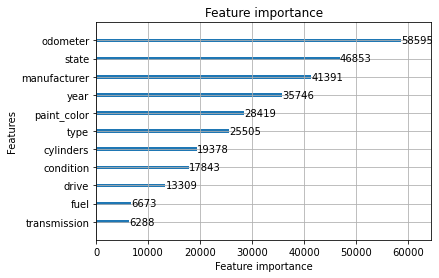

In [43]:
%matplotlib inline
#fig =  plt.figure(figsize = (5,5))
#axes = fig.add_subplot(111)
lgb.plot_importance(modelL)
#gif_lgb_feat_importances = plt.gcf()
plt.show()

In [44]:
def hyperopt_gb_score(params):
    clf = GradientBoostingRegressor(**params)
    current_score = cross_val_score(clf, train, target, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_gb = {
            'n_estimators': hp.choice('n_estimators', range(100, 500, 50)),
            'max_depth': hp.choice('max_depth', np.arange(2, 10, dtype=int))            
        }
 
best = fmin(fn=hyperopt_gb_score, space=space_gb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.8521612524445079                                                                                              
{'max_depth': 7, 'n_estimators': 400}                                                                           
0.8368698444228121                                                                                              
{'max_depth': 6, 'n_estimators': 200}                                                                           
0.8522638592574555                                                                                              
{'max_depth': 8, 'n_estimators': 250}                                                                           
0.8544679305102848                                                                                              
{'max_depth': 9, 'n_estimators': 300}                                                                           
0.8466183254564132                                                                              

In [45]:
params = space_eval(space_gb, best)
params

{'max_depth': 2, 'n_estimators': 150}

In [46]:
# Gradient Boosting Regression

gradient_boosting = GradientBoostingRegressor(**params)
gradient_boosting.fit(train, target)
acc_model(9,gradient_boosting,train,test)

target =  [26000  4800 13995 22995 14977]
ytrain =  [31221.23579382  9678.16801028 10652.59860735 19373.09065219
 18694.04774373]
acc(r2_score) for train = 75.76
acc(relative error) for train = 18.96
acc(rmse) for train = 413222.4
target_test = [35966  4500  6895  8997  9995]
ytest = [25827.59390954  9482.88515853  8464.08825856 10236.69055557
  7673.3248361 ]
acc(r2_score) for test = 76.08
acc(relative error) for test = 18.9
acc(rmse) for test = 411563.59


In [47]:
# Ridge Regressor

ridge = RidgeCV(cv=5)
ridge.fit(train, target)
acc_model(10,ridge,train,test)

target =  [26000  4800 13995 22995 14977]
ytrain =  [24899.94634533  7119.34541687 12081.13258236 20975.47798505
 16240.51141983]
acc(r2_score) for train = 58.38
acc(relative error) for train = 24.93
acc(rmse) for train = 541444.27
target_test = [35966  4500  6895  8997  9995]
ytest = [23856.7956296  11520.86800673 14412.24178981 13283.25319943
 11271.62268496]
acc(r2_score) for test = 58.66
acc(relative error) for test = 24.96
acc(rmse) for test = 541025.34


In [48]:
# Bagging Regressor

bagging = BaggingRegressor()
bagging.fit(train, target)
acc_model(11,bagging,train,test)

target =  [26000  4800 13995 22995 14977]
ytrain =  [28483.8         5839.         12966.         20884.5
 16082.06666667]
acc(r2_score) for train = 96.89
acc(relative error) for train = 5.57
acc(rmse) for train = 147911.64
target_test = [35966  4500  6895  8997  9995]
ytest = [29107.13333333  6328.4         6736.5         7318.4
  9998.8       ]
acc(r2_score) for test = 83.83
acc(relative error) for test = 13.57
acc(rmse) for test = 338345.41


In [49]:
# Extra Trees Regressor

etr = ExtraTreesRegressor()
etr.fit(train, target)
acc_model(12,etr,train,test)

target =  [26000  4800 13995 22995 14977]
ytrain =  [26000.          4800.         13995.         22995.
 15195.66666667]
acc(r2_score) for train = 99.92
acc(relative error) for train = 0.16
acc(rmse) for train = 24307.83
target_test = [35966  4500  6895  8997  9995]
ytest = [29539.3   4500.    6895.    8382.76 10275.  ]
acc(r2_score) for test = 85.23
acc(relative error) for test = 12.04
acc(rmse) for test = 323398.78


In [50]:
# AdaBoost Regression

Ada_Boost = AdaBoostRegressor()
Ada_Boost.fit(train, target)
acc_model(13,Ada_Boost,train,test)

target =  [26000  4800 13995 22995 14977]
ytrain =  [25533.46137787 11999.04559669 12786.30877617 20967.48100284
 18579.23505155]
acc(r2_score) for train = 59.53
acc(relative error) for train = 26.92
acc(rmse) for train = 533966.59
target_test = [35966  4500  6895  8997  9995]
ytest = [23391.22164276 14889.09667932 12786.30877617 14889.09667932
 12786.30877617]
acc(r2_score) for test = 59.77
acc(relative error) for test = 26.85
acc(rmse) for test = 533717.16


In [51]:
Voting_Reg = VotingRegressor(estimators=[('lin', linreg), ('ridge', ridge), ('sgd', sgd)])
Voting_Reg.fit(train, target)
acc_model(14,Voting_Reg,train,test)

target =  [26000  4800 13995 22995 14977]
ytrain =  [24692.54292413  7066.75367946 12218.26845757 21081.71710865
 16435.8503552 ]
acc(r2_score) for train = 58.36
acc(relative error) for train = 24.99
acc(rmse) for train = 541618.19
target_test = [35966  4500  6895  8997  9995]
ytest = [24110.30538507 11482.53699383 14291.22558275 13160.72547854
 11492.12021641]
acc(r2_score) for test = 58.61
acc(relative error) for test = 25.03
acc(rmse) for test = 541340.48


In [52]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Support Vector Machines', 'Linear SVR', 
              'MLPRegressor', 'Stochastic Gradient Decent', 
              'Decision Tree Regressor', 'Random Forest',  'XGB', 'LGBM',
              'GradientBoostingRegressor', 'RidgeRegressor', 'BaggingRegressor', 'ExtraTreesRegressor', 
              'AdaBoostRegressor', 'VotingRegressor'],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'd_train': acc_train_d,
    'd_test': acc_test_d,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [53]:
pd.options.display.float_format = '{:,.2f}'.format

In [54]:
print('Prediction accuracy for models by R2 criterion - r2_test')
models.sort_values(by=['r2_test', 'r2_train'], ascending=False)

Prediction accuracy for models by R2 criterion - r2_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
8,LGBM,91.07,86.10,10.89,13.49,"250,835.56","313,757.59"
12,ExtraTreesRegressor,99.92,85.23,0.16,12.04,"24,307.83","323,398.78"
6,Random Forest,97.82,85.19,4.91,12.83,"123,983.54","323,775.80"
7,XGB,87.77,84.37,13.02,14.50,"293,570.78","332,618.80"
11,BaggingRegressor,96.89,83.83,5.57,13.57,"147,911.64","338,345.41"
9,GradientBoostingRegressor,75.76,76.08,18.96,18.90,"413,222.40","411,563.59"
5,Decision Tree Regressor,99.92,73.33,0.16,15.96,"24,307.62","434,529.44"
3,MLPRegressor,61.52,62.23,24.15,24.06,"520,658.73","517,125.09"
13,AdaBoostRegressor,59.53,59.77,26.92,26.85,"533,966.59","533,717.16"
0,Linear Regression,58.38,58.66,24.93,24.96,"541,444.24","541,022.80"


In [55]:
print('Prediction accuracy for models by relative error - d_test')
models.sort_values(by=['d_test', 'd_train'], ascending=True)

Prediction accuracy for models by relative error - d_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
12,ExtraTreesRegressor,99.92,85.23,0.16,12.04,"24,307.83","323,398.78"
6,Random Forest,97.82,85.19,4.91,12.83,"123,983.54","323,775.80"
8,LGBM,91.07,86.10,10.89,13.49,"250,835.56","313,757.59"
11,BaggingRegressor,96.89,83.83,5.57,13.57,"147,911.64","338,345.41"
7,XGB,87.77,84.37,13.02,14.50,"293,570.78","332,618.80"
5,Decision Tree Regressor,99.92,73.33,0.16,15.96,"24,307.62","434,529.44"
9,GradientBoostingRegressor,75.76,76.08,18.96,18.90,"413,222.40","411,563.59"
3,MLPRegressor,61.52,62.23,24.15,24.06,"520,658.73","517,125.09"
0,Linear Regression,58.38,58.66,24.93,24.96,"541,444.24","541,022.80"
10,RidgeRegressor,58.38,58.66,24.93,24.96,"541,444.27","541,025.34"


In [56]:
print('Prediction accuracy for models by RMSE - rmse_test')
models.sort_values(by=['rmse_test', 'rmse_train'], ascending=True)

Prediction accuracy for models by RMSE - rmse_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
8,LGBM,91.07,86.10,10.89,13.49,"250,835.56","313,757.59"
12,ExtraTreesRegressor,99.92,85.23,0.16,12.04,"24,307.83","323,398.78"
6,Random Forest,97.82,85.19,4.91,12.83,"123,983.54","323,775.80"
7,XGB,87.77,84.37,13.02,14.50,"293,570.78","332,618.80"
11,BaggingRegressor,96.89,83.83,5.57,13.57,"147,911.64","338,345.41"
9,GradientBoostingRegressor,75.76,76.08,18.96,18.90,"413,222.40","411,563.59"
5,Decision Tree Regressor,99.92,73.33,0.16,15.96,"24,307.62","434,529.44"
3,MLPRegressor,61.52,62.23,24.15,24.06,"520,658.73","517,125.09"
13,AdaBoostRegressor,59.53,59.77,26.92,26.85,"533,966.59","533,717.16"
0,Linear Regression,58.38,58.66,24.93,24.96,"541,444.24","541,022.80"


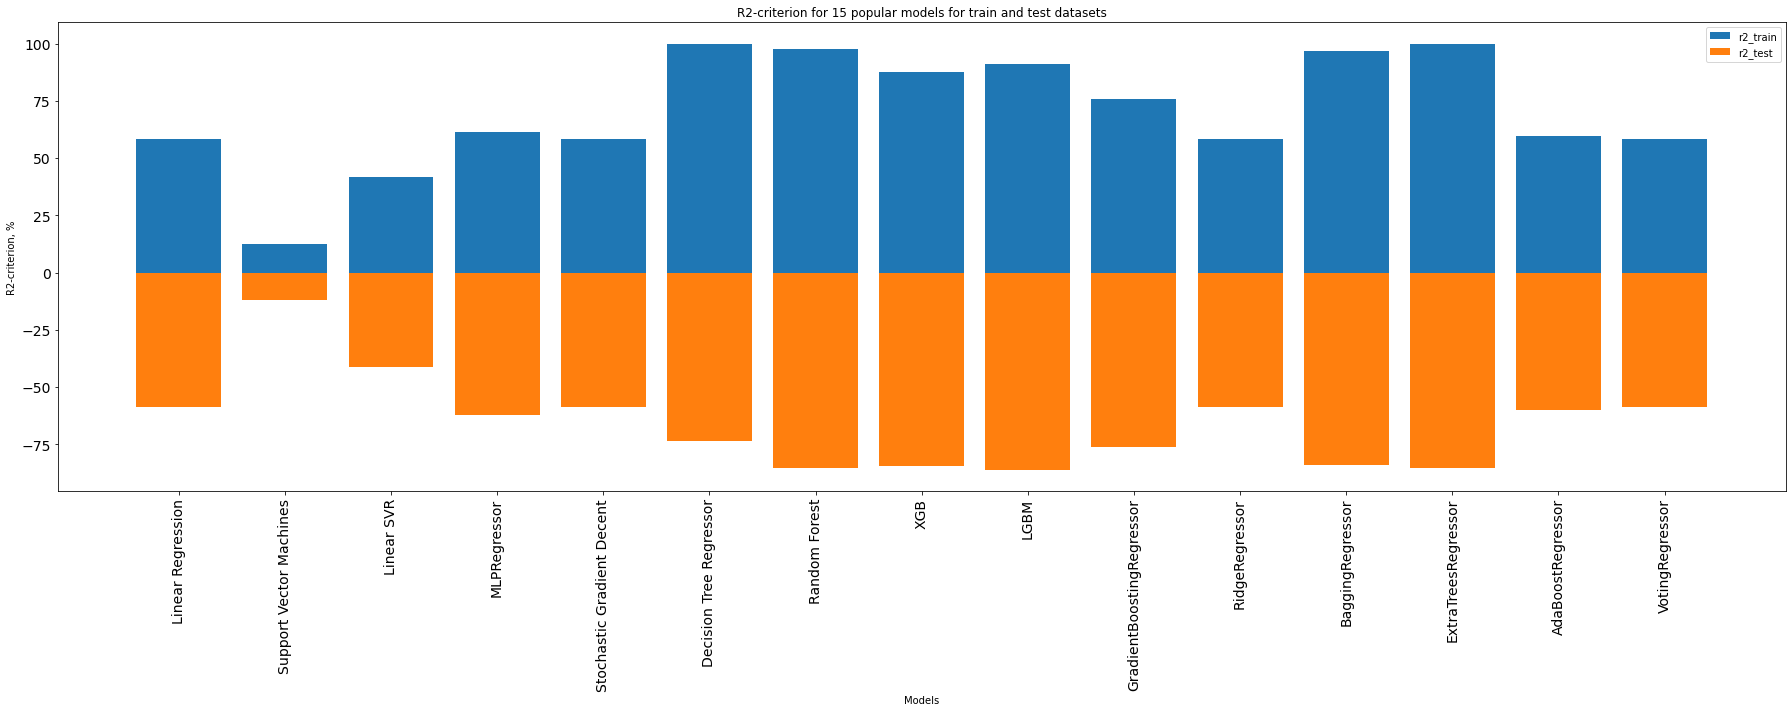

In [57]:
# Plot
%matplotlib inline
plt.figure(figsize=[25,10])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.bar(xx, models['r2_train'], label = 'r2_train')
plt.bar(xx, -1*models['r2_test'], label = 'r2_test')
plt.legend()
plt.title('R2-criterion for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('R2-criterion, %')
plt.xticks(xx, rotation='vertical')
plt.tight_layout()
fig_rmse = plt.gcf()
plt.show()
fig_rmse.savefig('graph_r2_score.png')

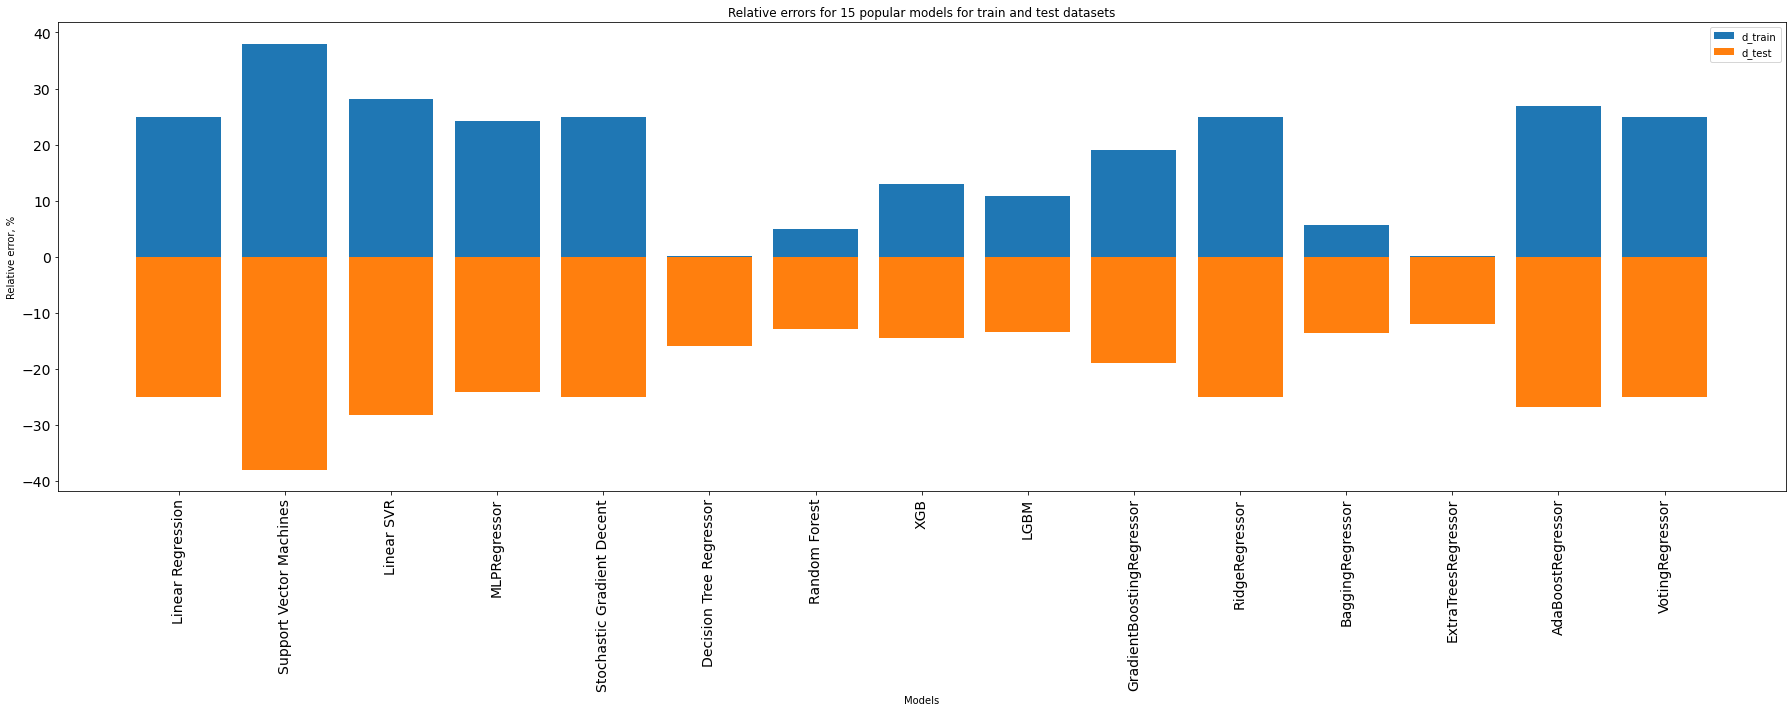

In [58]:
# Plot
plt.figure(figsize=[25,10])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.bar(xx, models['d_train'], label = 'd_train')
plt.bar(xx, -1*models['d_test'], label = 'd_test')
plt.legend()
plt.title('Relative errors for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Relative error, %')
plt.xticks(xx, rotation='vertical')
plt.tight_layout()
fig_rmse = plt.gcf()
plt.show()
fig_rmse.savefig('graph_relative_errors.png')

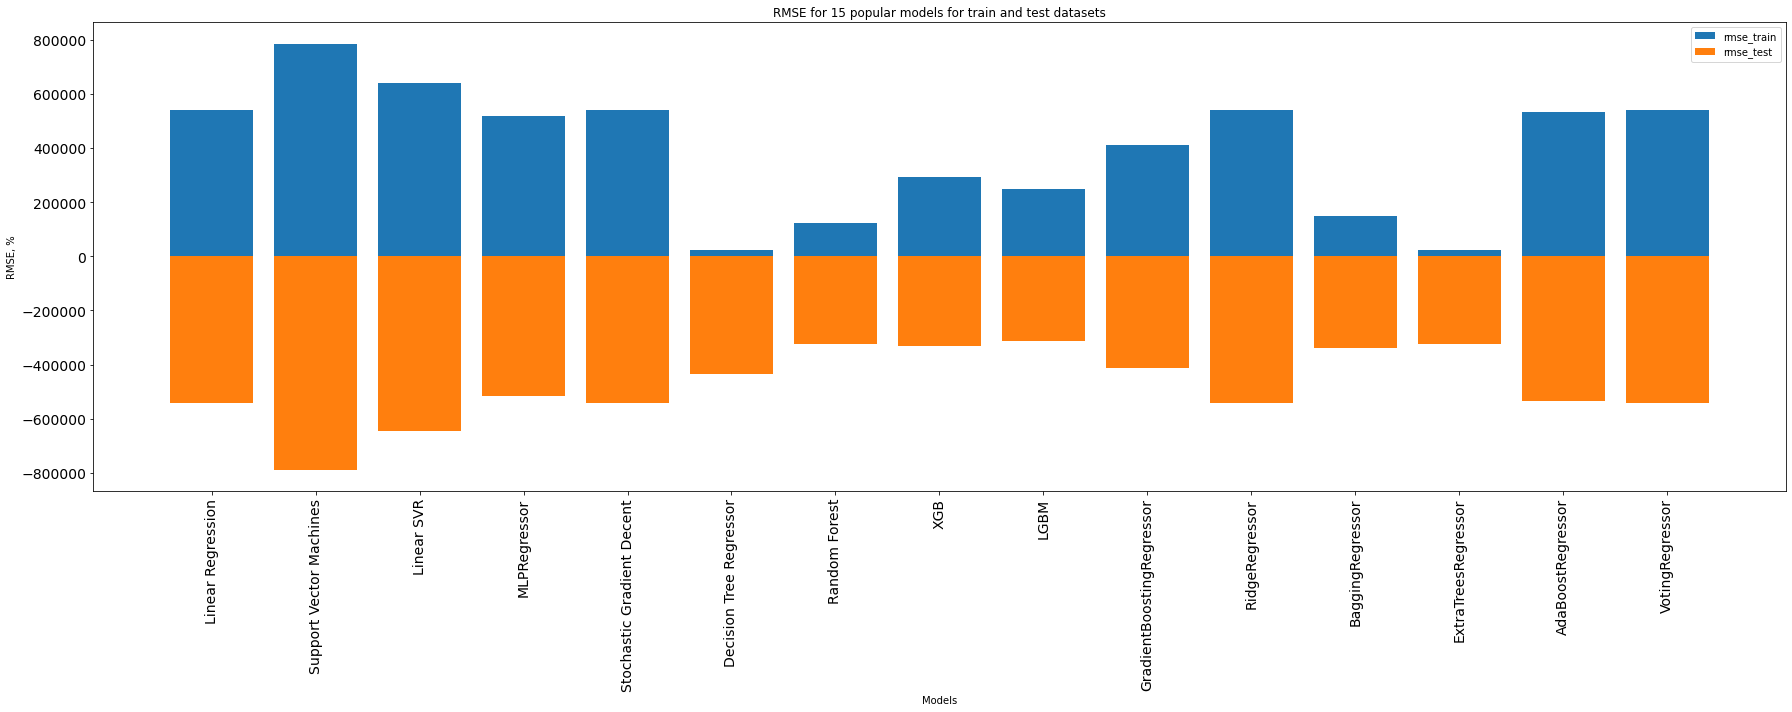

In [59]:
# Plot
plt.figure(figsize=[25,10])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.bar(xx, models['rmse_train'], label = 'rmse_train')
plt.bar(xx, -1*models['rmse_test'], label = 'rmse_test')
plt.legend()
plt.title('RMSE for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('RMSE, %')
plt.xticks(xx, rotation='vertical')
plt.tight_layout()
fig_rmse = plt.gcf()
plt.show()
fig_rmse.savefig('graph_rmse.png')